In [14]:
import numpy as np
import pandas as pd
import scipy.signal as sig
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt

from tslearn.preprocessing import TimeSeriesResampler, TimeSeriesScalerMinMax
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation
from tslearn.metrics import lb_envelope

import src.packages.db.db_connect as db
import src.packages.utils.dataset as ds

%matplotlib notebook

register_matplotlib_converters()

figsize=(9.8, 6)

In [7]:
# Dataset
axes = 'y_axis'
timestamp = 'timestampdata'

interval_sec = 25

dataset_raw, ts, te = ds.get_dataset_from_db(start_min=54, start_sec=41, interval_sec=interval_sec)

dataset_axes = dataset_raw[axes].values
dataset_timestamp = dataset_raw[timestamp]

In [8]:
# Series
default_series = pd.Series(dataset_axes)
series = pd.Series(dataset_axes, index=dataset_timestamp)

In [9]:
# Absolute
series = series.abs()

# Resample
resample_size = 2000 * interval_sec
default_series = pd.Series(TimeSeriesResampler(sz=resample_size).fit_transform(default_series).ravel())
series = pd.Series(TimeSeriesResampler(sz=resample_size).fit_transform(series).ravel())

# Envelope
env_low, env_up = lb_envelope(series, radius=35)
# env_low, env_up = lb_envelope(env_up, radius=15)
series = pd.Series(env_up.ravel())

In [10]:
# Scale to Sax
n_paa_segments = 2000 * interval_sec
n_sax_symbols = 20

sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)

min_scaler = min(sax.breakpoints_avg_middle_) + .2
max_scaler = max(sax.breakpoints_avg_middle_)

scaler = TimeSeriesScalerMinMax(min=min_scaler, max=max_scaler)
series = scaler.fit_transform(series)

sax_dataset_inv = sax.inverse_transform(sax.fit_transform(series))

sax_list = list(sax_dataset_inv.ravel())
idx_data = []

segment = True

for i in range(len(sax_list)):

    if sax_list[i] != sax.breakpoints_avg_middle_[0]:
        # idx_data.append(i)
        if not segment:
            idx_data.append(i)
        segment = True
    else:
        segment = False


50000


<IPython.core.display.Javascript object>


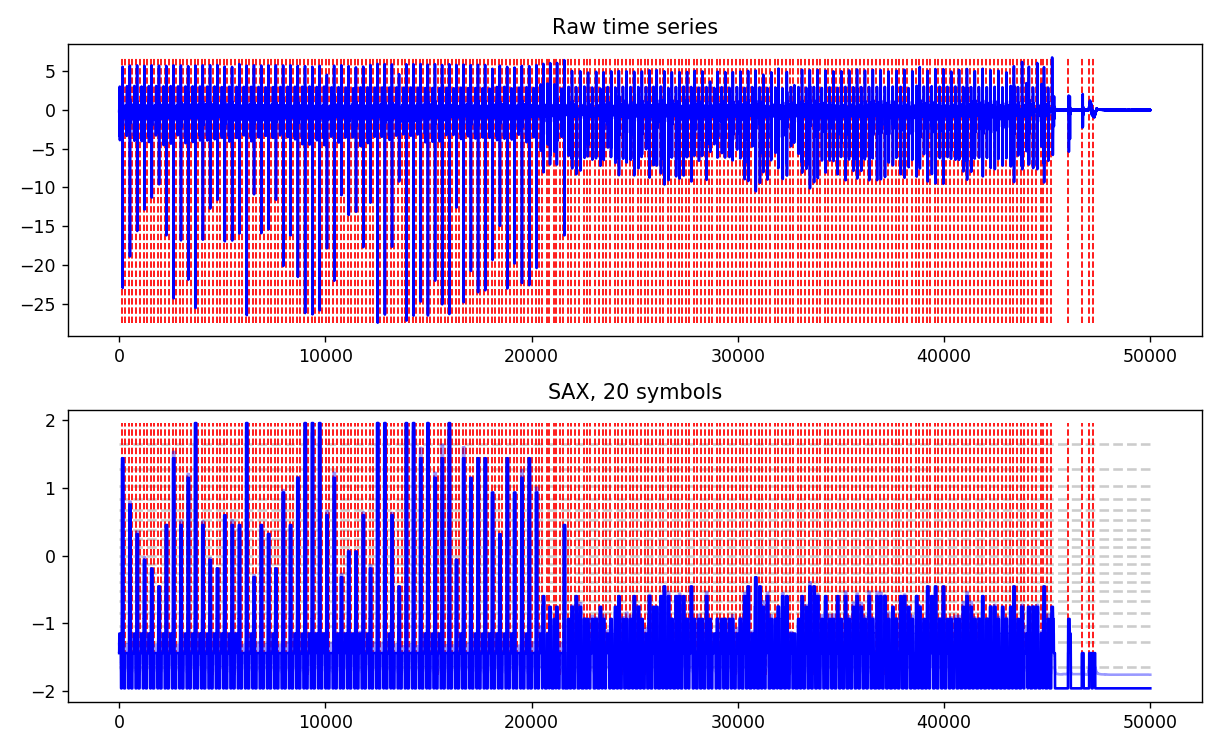

In [15]:
print('')
print(series.size)

# figsize=(14, 6)

plt.figure(figsize=figsize)
plt.subplot(2, 1, 1)  # First, raw time series
plt.plot(default_series.ravel(), "b-")
plt.vlines(idx_data, min(default_series), max(default_series), 'red', 'dashed', lw=1)

plt.title("Raw time series")

plt.subplot(2, 1, 2)  # Then SAX
plt.plot(series.ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), 'b-')
plt.hlines(sax.breakpoints_avg_ , 0, resample_size, 'gray', 'dashed', alpha=0.4)
plt.vlines(idx_data, min_scaler, max_scaler, 'r', 'dashed', lw=1)

plt.title("SAX, %d symbols" % n_sax_symbols)

plt.tight_layout()


plt.show()